In [1]:
#libraries needed
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import eval_chebyt
import sys
from scipy.linalg import eig


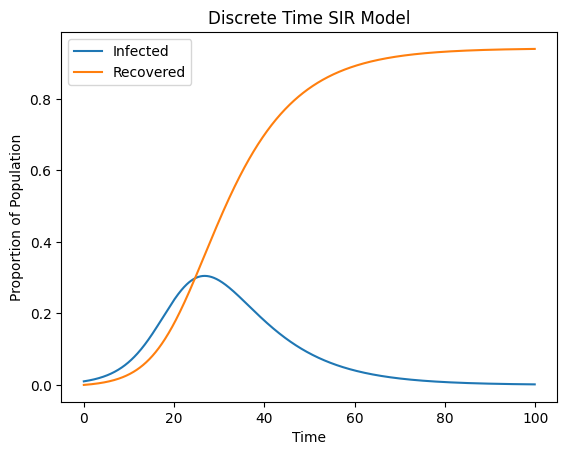

In [2]:
#SIR model one step at a time
def sir_step(I, R, beta, gamma, h):
    I_next = I + h * (beta * (1 - I - R) * I - gamma * I)
    R_next = R + h * gamma * I
    return I_next, R_next

#discrete time SIR model
def sir_discrete(I0, R0, beta, gamma, h, n_steps):
    I = np.zeros(n_steps)
    R = np.zeros(n_steps)
    
    I[0] = I0
    R[0] = R0
    
    for t in range(1, n_steps):
        I[t] = I[t-1] + h * (beta * (1 - I[t-1] - R[t-1]) * I[t-1] - gamma * I[t-1])
        R[t] = R[t-1] + h * gamma * I[t-1]

    
    return I, R

#plot just to check
I0 = 0.01
R0 = 0.0
beta = 0.3
gamma = 0.1
h = 0.1
n_steps = 1000   
I, R = sir_discrete(I0, R0, beta, gamma, h, n_steps)
time = np.arange(n_steps) * h
plt.plot(time, I, label='Infected')
plt.plot(time, R, label='Recovered')
plt.xlabel('Time')
plt.ylabel('Proportion of Population')
plt.legend()
plt.title('Discrete Time SIR Model')
plt.show()

[[ 0.5   0.3   1.    0.3  -0.82  0.5   0.15 -0.41 -0.5  -0.15  0.41]]
Singular values (min..max): 9.02e-16 .. 7.27e+01
Condition number of THETA_X: 8.07e+16
Min/Max column 2-norms of THETA_X: 2.06e+00 / 3.16e+01

||K_rls||_F      = 2.985040

Prediction errors on first 10 samples (RLS only):
i=0: RLS=1.423946e-03
i=1: RLS=1.400815e-03
i=2: RLS=1.377379e-03
i=3: RLS=1.353637e-03
i=4: RLS=1.329590e-03
i=5: RLS=1.305237e-03
i=6: RLS=1.280579e-03
i=7: RLS=1.255617e-03
i=8: RLS=1.230352e-03
i=9: RLS=1.204785e-03


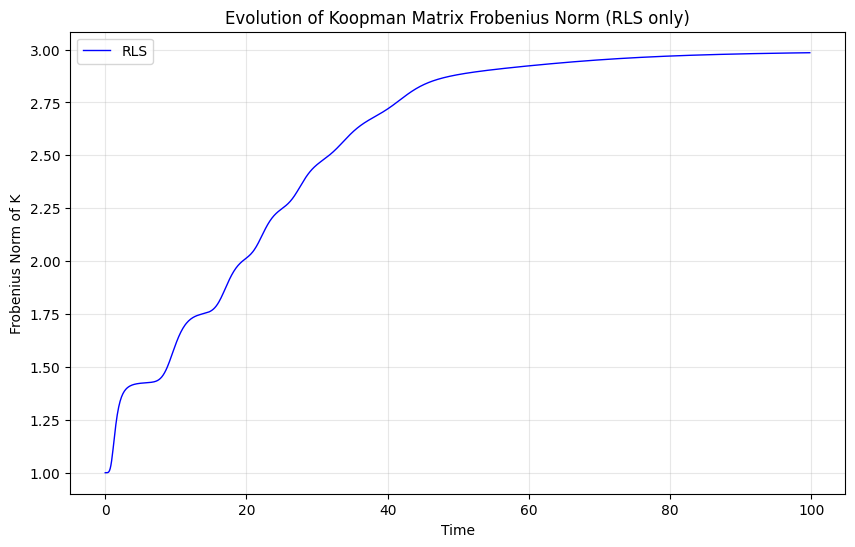

(38, 38)


In [3]:
#This cell should contain all the code to run recursive least squares with polynomial basis
# Koopman operator analysis on the SIR model (RLS-only, row-vector convention)

def  matrix_of_basis_functions(state, degree):
    x = state[0][0]
    y = state[1][0]
    basis = np.zeros((1, 2 + (degree + 1)**2))
    #first encode the identity functions
    basis[0, 0] = x
    basis[0, 1] = y
     #then the polynomial basis functions
    for k in range(2, basis.shape[1]):
        i = (k - 2) // (degree + 1)
        j = (k - 2) % (degree + 1)
        basis[0, k] = eval_chebyt(i, x) * eval_chebyt(j, y)
    return basis

def compute_K_rls(I0, R0, beta, gamma, h, n_steps, degree, alpha, lambda_rls):
    # Basis size
    n_basis = 2 + (degree + 1)**2
    
    # RLS state for row vector formulation: phi_next = phi @ K_rls
    P = alpha * np.eye(n_basis)
    K_rls = np.zeros((n_basis, n_basis))  # maps: phi (row) -> phi_next (row)
    
    I = I0
    R = R0
    
    for t in range(n_steps - 1):
        state = np.array([[I], [R]])
        phi = matrix_of_basis_functions(state, degree)  # shape (1, n_basis) - row vector

        I_next, R_next = sir_step(I, R, beta, gamma, h)
        state_next = np.array([[I_next], [R_next]])
        phi_next = matrix_of_basis_functions(state_next, degree)  # shape (1, n_basis) - row vector

        # Multi-output RLS (row vector form): phi_next = phi @ K_rls
        # Update: K <- K + k (y - phi K)
        # where k = (P phi^T) / (lambda + phi P phi^T)
        phi_flat = phi.flatten()            # (n_basis,)
        phi_next_flat = phi_next.flatten()  # (n_basis,)

        denom = (lambda_rls + phi_flat @ P @ phi_flat)
        K_gain = (P @ phi_flat) / denom              # shape (n_basis,)
        error_vec = (phi_next_flat - phi_flat @ K_rls)    # shape (n_basis,)
        K_rls = K_rls + np.outer(K_gain, error_vec)

        # Covariance update (Joseph form without noise term)
        P = (P - np.outer(K_gain, phi_flat) @ P) / lambda_rls

        # advance state
        I = I_next
        R = R_next
    
    return K_rls

print(matrix_of_basis_functions(np.array([[0.5],[0.3]]), 2))

# parameters
I = 0.01
R = 0.0
beta = 0.3
gamma = 0.1
h = 0.1
n_steps = 1000
degree = 5
alpha = 1000.0
lambda_rls = 1.0  # forgetting factor (1.0 => batch-equivalent weighting)

# Basis size
n_basis = 2 + (degree + 1)**2

# RLS state for row vector formulation: phi_next = phi @ K_rls
P = alpha * np.eye(n_basis)
K_rls = np.zeros((n_basis, n_basis))  # maps: phi (row) -> phi_next (row)

# Optional: collect batch data for diagnostics (conditioning)
THETA_Y = np.zeros((1, n_basis))
THETA_X = np.zeros((1, n_basis))

# values to record
K_norm = []
time_steps = []

for t in range(n_steps - 1):
    state = np.array([[I], [R]])
    phi = matrix_of_basis_functions(state, degree)  # shape (1, n_basis) - row vector

    I_next, R_next = sir_step(I, R, beta, gamma, h)
    state_next = np.array([[I_next], [R_next]])
    phi_next = matrix_of_basis_functions(state_next, degree)  # shape (1, n_basis) - row vector

    # keep data for diagnostics
    THETA_Y = np.vstack((THETA_Y, phi_next))
    THETA_X = np.vstack((THETA_X, phi))

    # Multi-output RLS (row vector form): phi_next = phi @ K_rls
    # Update: K <- K + k (y - phi K)
    # where k = (P phi^T) / (lambda + phi P phi^T)
    phi_flat = phi.flatten()            # (n_basis,)
    phi_next_flat = phi_next.flatten()  # (n_basis,)

    denom = (lambda_rls + phi_flat @ P @ phi_flat)
    K_gain = (P @ phi_flat) / denom              # shape (n_basis,)
    error_vec = (phi_next_flat - phi_flat @ K_rls)    # shape (n_basis,)
    K_rls = K_rls + np.outer(K_gain, error_vec)

    # Covariance update (Joseph form without noise term)
    P = (P - np.outer(K_gain, phi_flat) @ P) / lambda_rls

    # advance state
    I = I_next
    R = R_next

    K_norm.append(np.linalg.norm(K_rls, ord='fro'))
    time_steps.append(t * h)

# Final batch matrices for diagnostics
THETA_Y = THETA_Y[1:, :]
THETA_X = THETA_X[1:, :]

# Diagnostics: SVD spectrum, conditioning, and column norms
U, s, Vt = np.linalg.svd(THETA_X, full_matrices=False)
cond_X = (s[0] / s[-1]) if s[-1] > 0 else np.inf
col_norms = np.linalg.norm(THETA_X, axis=0)
print(f"Singular values (min..max): {s.min():.2e} .. {s.max():.2e}")
print(f"Condition number of THETA_X: {cond_X:.2e}")
print(f"Min/Max column 2-norms of THETA_X: {col_norms.min():.2e} / {col_norms.max():.2e}")

# Report RLS norm
print(f"\n||K_rls||_F      = {np.linalg.norm(K_rls, ord='fro'):.6f}")

# RLS-only prediction errors on first 10 samples (row form: phi_next = phi @ K)
print("\nPrediction errors on first 10 samples (RLS only):")
for i in range(min(10, THETA_Y.shape[0])):
    xrow = THETA_X[i, :]
    y_true = THETA_Y[i, :]
    print(f"i={i}: RLS={np.linalg.norm(xrow @ K_rls - y_true):.6e}")

# Plot evolution of K norm (RLS only)
plt.figure(figsize=(10, 6))
plt.plot(time_steps, K_norm, 'b-', label='RLS', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Frobenius Norm of K')
plt.title('Evolution of Koopman Matrix Frobenius Norm (RLS only)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(K_rls.shape)


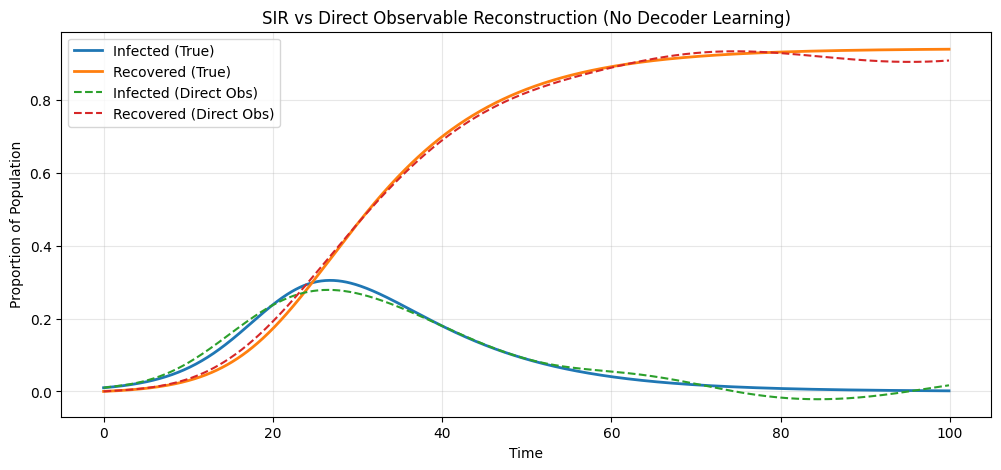

max eigenvalue:  (0.9999902805619257+0j)


In [4]:
# Alternative reconstruction: Direct observable evaluation (no learned decoder)
# Instead of learning V and advancing coefficients in eigenspace,
# we directly evaluate g(x) = B^T Ψ(x) at each state x_t = F^t(x_0)
# by evolving the state in the lifted space and applying B to extract [I, R]

# This approach:
# 1. Lifts x_0 to φ_0 = Ψ(x_0) as a row vector (1 × n_basis)
# 2. Advances φ_{t+1} = φ_t K in lifted space
# 3. Extracts physical state via g(x_t) = φ_t B (no decoder learning)

# Generate true SIR data for reference
I0 = 0.01
R0 = 0.0
I_data_alt = np.zeros(n_steps)
R_data_alt = np.zeros(n_steps)
I_data_alt[0] = I0
R_data_alt[0] = R0
for t in range(n_steps - 1):
    In, Rn = sir_step(I0, R0, beta, gamma, h)
    I0, R0 = In, Rn
    I_data_alt[t + 1] = I0
    R_data_alt[t + 1] = R0

# Decoder selection matrix B (same as before)
B_alt = np.zeros((n_basis, 2))
B_alt[0, 0] = 1.0  # I coordinate
B_alt[1, 1] = 1.0  # R coordinate

# Initialize reconstruction
I0 = I_data_alt[0]
R0 = R_data_alt[0]
I_state_direct = np.zeros(n_steps)
R_state_direct = np.zeros(n_steps)
I_state_direct[0] = I0
R_state_direct[0] = R0

# Lift initial state as ROW vector (1 × n_basis)
phi = matrix_of_basis_functions(np.array([[I0], [R0]]), degree)

for t in range(n_steps - 1):
    # Advance in lifted space: φ_{t+1} = φ_t K (row × matrix)
    # K_rls is now trained for row vectors: phi_next = phi @ K_rls
    phi = phi @ K_rls
    
    # Extract physical state directly: g(x_t) = φ_t B (1×n_basis) @ (n_basis×2) = (1×2)
    x = phi @ B_alt
    I_next = float(x[0, 0])
    R_next = float(x[0, 1])
    I_state_direct[t + 1] = I_next
    R_state_direct[t + 1] = R_next

# Plot comparison
time = np.arange(n_steps) * h
plt.figure(figsize=(12, 5))
plt.plot(time, I_data_alt, label='Infected (True)', lw=2)
plt.plot(time, R_data_alt, label='Recovered (True)', lw=2)
plt.plot(time, I_state_direct, '--', label='Infected (Direct Obs)', lw=1.5)
plt.plot(time, R_state_direct, '--', label='Recovered (Direct Obs)', lw=1.5)
plt.xlabel('Time')
plt.ylabel('Proportion of Population')
plt.legend()
plt.title('SIR vs Direct Observable Reconstruction (No Decoder Learning)')
plt.grid(True, alpha=0.3)
plt.show()

eigenvalues, eigenvectors = np.linalg.eig(K_rls)
print("max eigenvalue: ", np.max(eigenvalues))

In [5]:
# #This is the full simulation 
# def actual_system(I, R, beta, gamma, h, noise_std):
#     I_noisy = I + np.random.normal(0, noise_std)
#     R_noisy = R + np.random.normal(0, noise_std)
#     # Clamp to valid range [0, 1] to prevent numerical issues
#     I_noisy = np.clip(I_noisy, 0.0, 1.0)
#     R_noisy = np.clip(R_noisy, 0.0, 1.0)
#     I_next, R_next = sir_step(I_noisy, R_noisy, beta, gamma, h)
#     # Clamp outputs as well
#     I_next = np.clip(I_next, 0.0, 1.0)
#     R_next = np.clip(R_next, 0.0, 1.0)
#     return I_next, R_next

# # Parameters
# I0 = 0.01
# R0 = 0.0
# beta = 0.3
# gamma = 0.1
# h = 0.1
# n_steps = 500
# degree = 5
# alpha = 1000.0
# lambda_rls = 0.99
# noise_std = 0.01
# warmup_steps = 50
# C = 10000.0  #transmission cost
# #come back and do this, but only do only policy per iteration, but still use the same noise 
# #allow user to choose the policy 
# #maybe pregenerate noise to make sure we are using the same noise 
# #compare each one separately. The alternating shouldnt have such a high cost. This is because the age of information function
# #should decrease after a transmission and such, but right now it is only looking at the age of information cost function 
# #from the optimal policy
# #or maybe kee
# def run_simulation(I0, R0, beta, gamma, h, n_steps, degree, alpha, lambda_rls, noise_std, warmup_steps, C):

#     # Basis size
#     n_basis = 2 + (degree + 1)**2

#     # RLS state for row vector formulation: phi_next = phi @ K_rls
#     P_noisy = alpha * np.eye(n_basis)
#     K_rls_noise = np.zeros((n_basis, n_basis))  # Koopman trained on noisy data
#     K_rls_no_noise = K_rls.copy()  # Initialize noise-free koopman from previous cell

#     I_prev = I0
#     R_prev = R0

#     # Values to record
#     base_station_I_vals = [I_prev]
#     base_station_R_vals = [R_prev]
#     norm_tracker = [0]
#     error_tracker = [0]  # Track error values
#     time_tracker = [0]   # Track time steps for error
#     k0_list = [0]  # list of time steps when data was sent
#     #now look at total cost to compare with some other policies 
#     total_cost_tracker = [0] #this is the cost of the actual policy, the koopman based one
#     alternating_policy_cost = [0] #transmit then dont 
#     for k in range(1, n_steps):
#         # Actual system evolution
#         I, R = actual_system(I_prev, R_prev, beta, gamma, h, noise_std)
#         state = np.array([[I], [R]])
        
#         data_sent_this_step = False
        
#         # Warmup period: send data every time step
#         if k < warmup_steps:
#             base_station_I_vals.append(I)
#             base_station_R_vals.append(R)
#             data_sent_this_step = True
#             k0_list.append(k)
#             if k % 10 == 0:  # Print every 10 steps to reduce output
#                 #print(f"Warmup: data sent at step {k}")
#                 pass
#             #update all the trackers 
#             error_tracker.append(error_tracker[-1])
#             time_tracker.append(k)
#             total_cost_tracker.append(0) #these are both zero for normalization
#             alternating_policy_cost.append(0)
        
#         # Post-warmup: check error and decide whether to send
#         else:
#             # Get last received state at base station
#             I_last = base_station_I_vals[-1]
#             R_last = base_station_R_vals[-1]
#             last_state = np.array([[I_last], [R_last]])
#             phi_last = matrix_of_basis_functions(last_state, degree)
            
#             # Calculate how much time has passed since last data transmission
#             delta = k - k0_list[-1]
            
#             # Error bound calculation (using more stable formulation)
#             K_noise_norm = np.linalg.norm(K_rls_noise, ord='fro')
#             K_no_noise_norm = np.linalg.norm(K_rls_no_noise, ord='fro')
#             phi_norm = np.linalg.norm(phi_last)
            
#             error = phi_norm * (K_noise_norm**delta + K_no_noise_norm**delta)
#             #error = 1 * (K_noise_norm**delta + K_no_noise_norm**delta)

#             # Track error evolution
#             error_tracker.append(error)
#             time_tracker.append(k)
#             #this is the alternating polucy for comparison
#             if (k % 2 == 0):
#                 alternating_policy_cost.append(alternating_policy_cost[-1] + error)
#             else:
#                 alternating_policy_cost.append(alternating_policy_cost[-1] + C)
#             # If error exceeds threshold, send data
#             if error > C:
#                 base_station_I_vals.append(I)
#                 base_station_R_vals.append(R)
#                 data_sent_this_step = True
#                 k0_list.append(k)
#                 total_cost_tracker.append((total_cost_tracker[-1] + C))
#                 #print(f"Post-warmup: data sent at step {k}, error={error:.4f}, delta={delta}")
#             else: #dont send data 
#                 total_cost_tracker.append(total_cost_tracker[-1] + error)
        
#         # Update Koopman operator if data was sent
#         if data_sent_this_step:
#             # Get previous state (second-to-last in base station arrays)
#             state_prev = np.array([[base_station_I_vals[-2]], [base_station_R_vals[-2]]])
#             phi_prev = matrix_of_basis_functions(state_prev, degree)  # (1, n_basis)
            
#             # Check if data is consecutive
#             time_gap = k0_list[-1] - k0_list[-2]
            
#             if time_gap == 1:
#                 # Consecutive: use direct measurement
#                 phi_predicted = phi_prev
#             else:
#                 # Non-consecutive: predict forward using K_rls_noise
#                 phi_predicted = phi_prev.copy()
#                 for _ in range(time_gap):
#                     phi_predicted = phi_predicted @ K_rls_noise
            
#             # Current measurement (just received)
#             phi_current = matrix_of_basis_functions(state, degree)
            
#             # RLS update for K_rls_noise
#             phi_pred_flat = phi_predicted.flatten()  # (n_basis,)
#             phi_curr_flat = phi_current.flatten()    # (n_basis,)
            
#             denom_noisy = (lambda_rls + phi_pred_flat @ P_noisy @ phi_pred_flat)
#             K_gain_noisy = (P_noisy @ phi_pred_flat) / denom_noisy  # (n_basis,)
#             error_vec_noisy = (phi_curr_flat - phi_pred_flat @ K_rls_noise)  # (n_basis,)
#             K_rls_noise = K_rls_noise + np.outer(K_gain_noisy, error_vec_noisy)
            
#             # Covariance update
#             P_noisy = (P_noisy - np.outer(K_gain_noisy, phi_pred_flat) @ P_noisy) / lambda_rls
            
#             # Track norm evolution
#             norm_tracker.append(np.linalg.norm(K_rls_noise, ord='fro'))
#         if((data_sent_this_step == False) and (k >= warmup_steps)):
#             #if data is not sent, still append to norm tracker to be same length
#             norm_tracker.append(norm_tracker[-1])
        
#         # Advance state
#         I_prev = I
#         R_prev = R

#     return base_station_I_vals, base_station_R_vals, k0_list, norm_tracker, error_tracker, time_tracker, K_rls_noise, K_rls_no_noise, total_cost_tracker, alternating_policy_cost

# base_station_I_vals, base_station_R_vals, k0_list, norm_tracker, error_tracker, time_tracker, K_rls_noise, K_rls_no_noise, total_cost_tracker, alternating_policy_cost = \
#     run_simulation(I0, R0, beta, gamma, h, n_steps, degree, alpha, lambda_rls, noise_std, warmup_steps, C)
# # Plot the received data values at base station
# plt.figure(figsize=(10, 6))
# plt.scatter(k0_list, base_station_I_vals, color='blue', label='Infected at Base Station', s=10)
# plt.scatter(k0_list, base_station_R_vals, color='orange', label='Recovered at Base Station', s=10)
# plt.axvline(x=50, color='pink', linestyle='--', label='End of Warm-up Period')
# plt.xlabel('Time Step')
# plt.ylabel('Proportion of Population')
# plt.title(f'Data Received at Base Station Over Time')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.savefig("./received_data.png")
# plt.show()

# # Plot error evolution with threshold
# plt.figure(figsize=(10, 6))
# plt.plot(time_tracker, error_tracker, marker = 'o', linestyle = '--', color='red', label='Error', linewidth=1)

# plt.axhline(y=C, color='black', linestyle='--', linewidth=2, label=f'Threshold C={C}')
# plt.axvline(x=50, color='pink', linestyle='--', label='End of Warm-up Period')
# plt.xlabel('Time Step')
# plt.ylabel('f($\Delta$) value')
# plt.title(' f($\Delta$) Evolution Over Time')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.yscale('log')
# plt.savefig("./error_function.png")
# plt.show()

# # Plot the norm tracker
# plt.figure(figsize=(10, 6))
# plt.plot(norm_tracker, color='green', label='Frobenius Norm of K_rls_noise')
# plt.axvline(x=50, color='pink', linestyle='--', label='End of Warm-up Period')
# plt.xlabel('Update Step')
# plt.ylabel('Frobenius Norm')
# plt.title('Evolution of Koopman Matrix Frobenius Norm with Updates')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.show()



# #total cost plot, compare with only transmitting 
# #transmit at every step is zero unitl warm up is done
# transmit_every_step =  [0 for i in range(warmup_steps)]
# transmit_every_step += [i * C for i in range(len(total_cost_tracker)+ 1 - warmup_steps)]
# plt.figure(figsize=(10, 6))
# plt.plot(total_cost_tracker, color = 'blue', label = 'threshold policy')
# plt.plot(transmit_every_step, color = 'green', label = 'transmit at every step')
# plt.plot(alternating_policy_cost, color = 'red', label = 'alternating policy')
# plt.axvline(x=50, color='pink', linestyle='--', label='End of Warm-up Period')
# plt.xlabel('Update Step')
# plt.ylabel('Cost')
# plt.title('Cost Evolution')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.savefig("./cost_funtion_plots.png")
# plt.show()


# print(f"\nTotal data transmissions: {len(k0_list)}")
# print(f"Data sent during warmup: {warmup_steps}")
# print(f"Data sent post-warmup: {len(k0_list) - warmup_steps}")
# print(f"Final K_rls_noise norm: {np.linalg.norm(K_rls_noise, ord='fro'):.6f}")
# print(f"Communication Percentage: {100*(len(k0_list)/n_steps):.1f}%")
# print("learned noisy K dimensions: ", K_rls_noise.shape)
# print("Precomuted noiseless K dimensions: ", K_rls_no_noise.shape)

# #print lengths of trackers to make sure they are all the same
# print("norm_tracker: ", len(norm_tracker))
# print("cost tracker: ", len(total_cost_tracker))

# C_values = [10, 50, 100, 250, 500, 750, 1000, 3000, 5000, 7500, 10000]
# cost_comp_altern_diff = [] #alternating policy difference vs koopman
# cost_comp_always_diff = [] # always transmit cost difference with koopman
# for C_val in C_values:
#     _, _, _, _, _, _, _, _, total_cost_tracker_C = \
#         run_simulation(I_actual_vals, R_actual_vals, n_steps, degree, alpha, lambda_rls, warmup_steps, C_val)
    
#     # Convert to numpy arrays for element-wise operations
#     total_cost_array = np.array(total_cost_tracker_C)
    
#     # Always transmit cost tracker
#     transmit_every_step =  [0 for i in range(warmup_steps)]
#     transmit_every_step += [i * C_val for i in range(len(total_cost_tracker_C) - warmup_steps)]
#     always_transmit_array = np.array(transmit_every_step)
    
#     # Average distance between policies
#     avg_distance_always = np.mean(np.abs(always_transmit_array - total_cost_array))
    
#     cost_comp_always_diff.append(avg_distance_always)
    
#     #print(f"C={C_val}: Avg distance to Alternating={avg_distance_alternating:.1f}, Avg distance to Always={avg_distance_always:.1f}")

# #plotting the sensitivity analysis
# plt.figure(figsize=(10, 6))
# plt.plot(C_values, cost_comp_always_diff, marker='s', linestyle='-', label='Avg Distance: Always Transmit vs Koopman')
# plt.xlabel('Transmission Cost C')
# plt.ylabel('Average Absolute Distance')
# plt.title('Sensitivity Analysis, Difference between policies')
# plt.legend()
# plt.grid(True, alpha=0.3)
# #plt.savefig("./sensitivity_analysis_C.png")
# plt.show()

# #check to see how many points were received at the base station #should also equal number of times transmissions occured


max eigenvalue:  (0.9999902805619257+0j)
Preocomputed K_rls_noise norm:  5.189398578102009
found threshold:  3
Preocomputed K_rls_noise norm:  5.189398578102009
found threshold:  3
Max eigenvalue no noise:  (1.0013511554383274+0.010479352843858048j)
Max eigenvalue with noise:  (1.0195849380694206+0j)
dominant eigenvector no noise norm:  1.0
dominant eigenvector with noise norm:  1.0


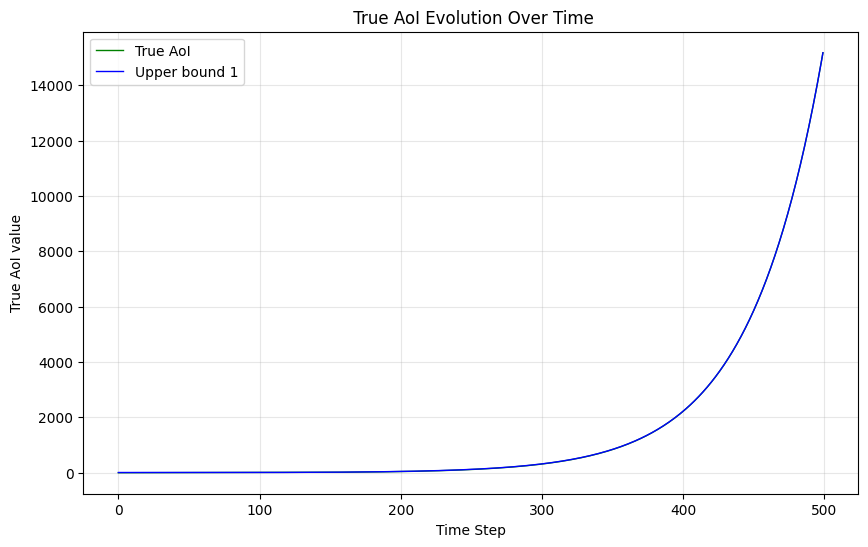

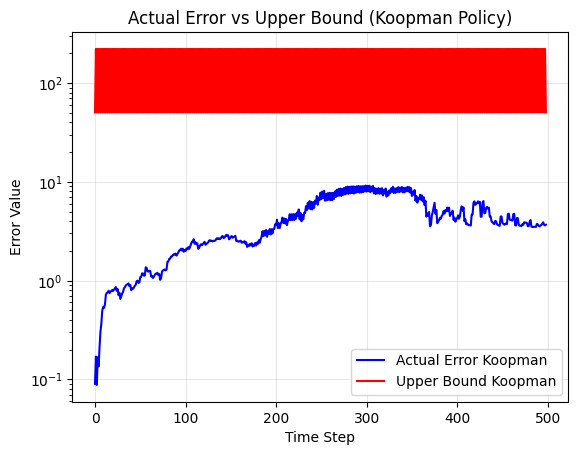

[ 0.00000000e+00  0.00000000e+00  1.58617880e-01 -3.74552402e-02
  7.36474619e-02  7.35355555e-02  0.00000000e+00  0.00000000e+00
 -7.22805243e-02  6.98603575e-02  1.14191229e-01  1.05652370e-01
  0.00000000e+00  0.00000000e+00  1.26112309e-02 -2.42278997e-02
  4.25048847e-02  3.76126058e-02  0.00000000e+00  0.00000000e+00
  4.23674710e-02  4.02479460e-02  4.03115039e-02  3.17556822e-02
  0.00000000e+00  0.00000000e+00  1.33712999e-01 -9.72716365e-02
  3.79416084e-02  2.58632185e-02  0.00000000e+00  0.00000000e+00
 -4.04255531e-02 -2.77748717e-02 -4.08522662e-02 -3.85049349e-02
  0.00000000e+00  0.00000000e+00  7.47221366e-02 -1.24939810e-01
  1.77322321e-02  1.63318323e-02  0.00000000e+00  0.00000000e+00
 -1.03071997e-02  9.27031384e-02  2.35787305e-02  2.35158560e-02
  0.00000000e+00  0.00000000e+00 -1.15229368e-01  8.94049368e-02
 -6.92288402e-03 -8.43849198e-03  0.00000000e+00  0.00000000e+00
 -2.40184092e-01 -3.25075711e-02  5.65476922e-02  5.43238332e-02
  0.00000000e+00  0.00000

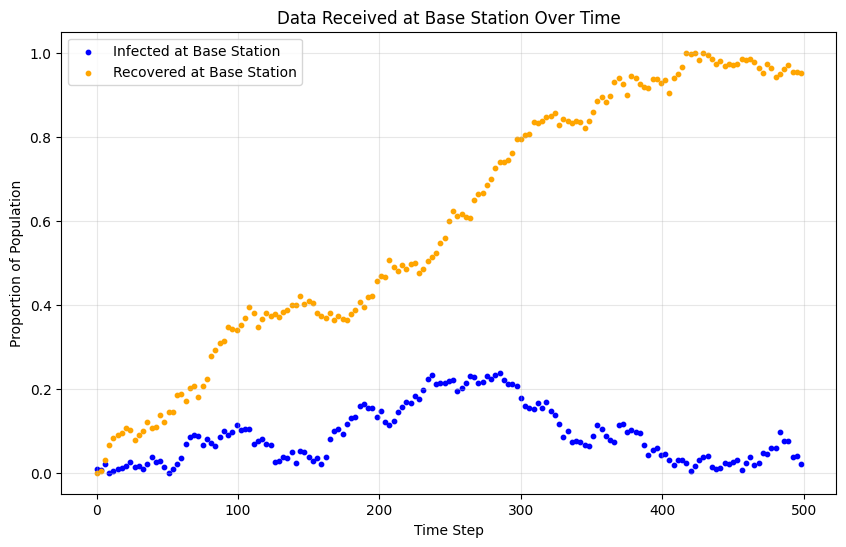

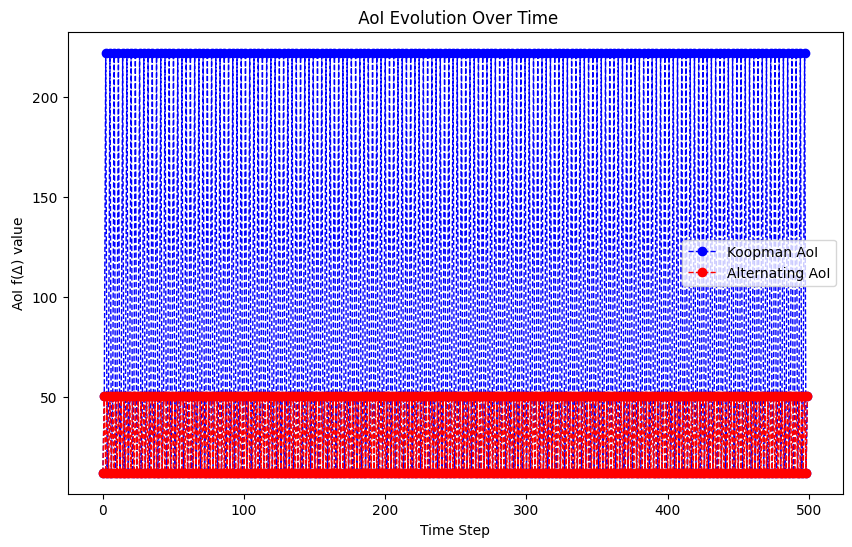

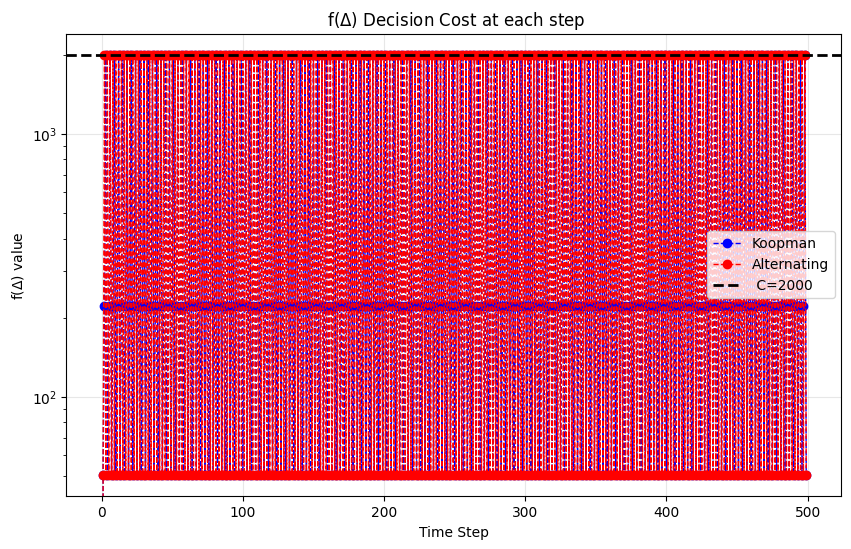

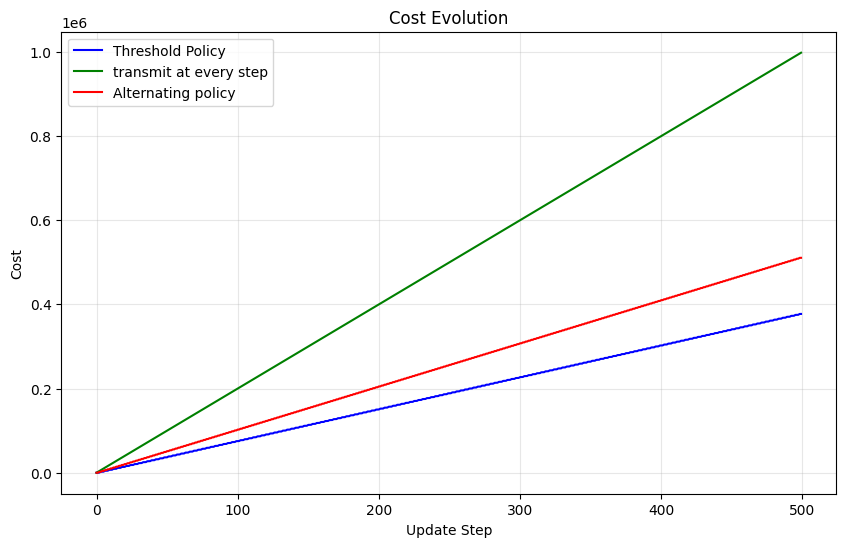


Total data transmissions: 250
Data sent during warmup: 75
Data sent post-warmup: 175
Final K_rls_noise norm: 5.189399
Communication Percentage: 50.0%
learned noisy K dimensions:  (51, 51)
Precomuted noiseless K dimensions:  (51, 51)
norm_tracker:  1
cost tracker:  500
Preocomputed K_rls_noise norm:  5.189398578102009
found threshold:  1
Preocomputed K_rls_noise norm:  5.189398578102009
found threshold:  1
Preocomputed K_rls_noise norm:  5.189398578102009
found threshold:  1
Preocomputed K_rls_noise norm:  5.189398578102009
found threshold:  1
Preocomputed K_rls_noise norm:  5.189398578102009
found threshold:  1
Preocomputed K_rls_noise norm:  5.189398578102009
found threshold:  1
Preocomputed K_rls_noise norm:  5.189398578102009
found threshold:  1
Preocomputed K_rls_noise norm:  5.189398578102009
found threshold:  1
Preocomputed K_rls_noise norm:  5.189398578102009
found threshold:  2
Preocomputed K_rls_noise norm:  5.189398578102009
found threshold:  2
Preocomputed K_rls_noise norm:

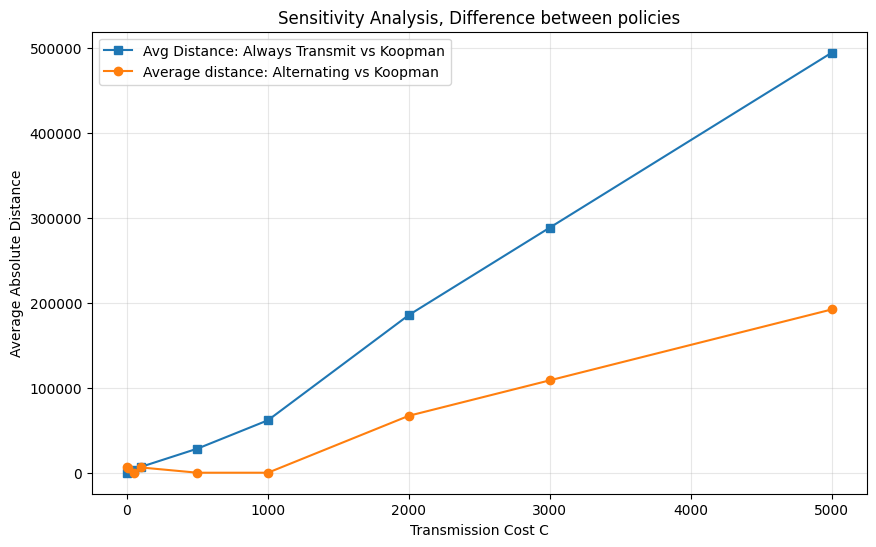

250
250


In [6]:
#This is the full simulation 
def actual_system(I, R, beta, gamma, h, noise_std):
    I_noisy = I + np.random.normal(0, noise_std)
    R_noisy = R + np.random.normal(0, noise_std)
    # Clamp to valid range [0, 1] to prevent numerical issues
    I_noisy = np.clip(I_noisy, 0.0, 1.0)
    R_noisy = np.clip(R_noisy, 0.0, 1.0)
    I_next, R_next = sir_step(I_noisy, R_noisy, beta, gamma, h)
    # Clamp outputs as well
    I_next = np.clip(I_next, 0.0, 1.0)
    R_next = np.clip(R_next, 0.0, 1.0)
    return I_next, R_next

# Helper functions for RLS update and AoI cost calculation
def rls_update(P_noisy, base_station_I_vals, base_station_R_vals, k0_list, state, degree, lambda_rls, K_rls_noise):
    # Get previous state (second-to-last in base station arrays)
    state_prev = np.array([[base_station_I_vals[-2]], [base_station_R_vals[-2]]])
    phi_prev = matrix_of_basis_functions(state_prev, degree)  # (1, n_basis)
    
    # Check if data is consecutive
    time_gap = k0_list[-1] - k0_list[-2]
    
    if time_gap == 1:
        # Consecutive: use direct measurement
        phi_predicted = phi_prev
    else:
        # Non-consecutive: predict forward using K_rls_noise
        phi_predicted = phi_prev.copy()
        for _ in range(time_gap):
            phi_predicted = phi_predicted @ K_rls_noise
    
    # Current measurement (just received)
    phi_current = matrix_of_basis_functions(state, degree)
    
    # RLS update for K_rls_noise
    phi_pred_flat = phi_predicted.flatten()  # (n_basis,)
    phi_curr_flat = phi_current.flatten()    # (n_basis,)
    
    denom_noisy = (lambda_rls + phi_pred_flat @ P_noisy @ phi_pred_flat)
    K_gain_noisy = (P_noisy @ phi_pred_flat) / denom_noisy  # (n_basis,)
    error_vec_noisy = (phi_curr_flat - phi_pred_flat @ K_rls_noise)  # (n_basis,)
    K_rls_noise = K_rls_noise + np.outer(K_gain_noisy, error_vec_noisy)
    
    # Covariance update
    P_noisy = (P_noisy - np.outer(K_gain_noisy, phi_pred_flat) @ P_noisy) / lambda_rls
    return K_rls_noise, P_noisy

def calculate_AoI_cost(base_station_I_vals, base_station_R_vals, k0_list, k, degree, K_rls_noise, K_rls_no_noise):
    # # Get last received state at base station
    # I_last = base_station_I_vals[-1]
    # R_last = base_station_R_vals[-1]
    # last_state = np.array([[I_last], [R_last]])
    # phi_last = matrix_of_basis_functions(last_state, degree)
    
    # # Calculate how much time has passed since last data transmission
    delta = k - k0_list[-1]
    K_hat_delta = np.linalg.matrix_power(K_rls_noise, delta)
    K_delta = np.linalg.matrix_power(K_rls_no_noise, delta)
    #this is a more stable upper bound since it does not rely on state 
    return np.sqrt(38) * np.linalg.norm(K_rls_no_noise, ord='fro') **delta +  \
           np.sqrt(38) * np.linalg.norm(K_rls_noise, ord='fro') **delta
    
    return np.linalg.norm(phi_last @ K_hat_delta) + np.linalg.norm(phi_last @ K_delta)
    # Error bound calculation
    K_noise_norm = np.linalg.norm(K_rls_noise, ord='fro')
    K_no_noise_norm = np.linalg.norm(K_rls_no_noise, ord='fro')
    phi_norm = np.linalg.norm(phi_last)
    
    error = phi_norm * (K_noise_norm**delta + K_no_noise_norm**delta)
    return error


def upper_upper_bound(K_rls_no_noise, K_rls_noise, delta):
    return np.sqrt(38) * np.linalg.norm(K_rls_no_noise, ord='fro') **delta +  \
           np.sqrt(38) * np.linalg.norm(K_rls_noise, ord='fro') **delta

def sum_to_h(H, K_rls_no_noise, K_rls_noise):
    sum = 0
    for i in range(1, H+1):
        sum = sum + upper_upper_bound(K_rls_no_noise, K_rls_noise, i)
    return sum

###################################################################################
# Precompute all SIR states beforehand
I_actual_vals = [I0]
R_actual_vals = [R0]
noise_std = 0.01
for i in range(1, n_steps):
    I, R = actual_system(I_actual_vals[-1], R_actual_vals[-1], beta, gamma, h, noise_std)
    I_actual_vals.append(I)
    R_actual_vals.append(R)
################################################################################
# Run simulation with threshold policy only
def run_simulation(policy, I_actual_vals, R_actual_vals, degree, alpha, lambda_rls, C):

    # Basis size
    n_basis = 2 + (degree + 1)**2
    n_steps = len(I_actual_vals)
    # RLS state for row vector formulation: phi_next = phi @ K_rls
    P_noisy = alpha * np.eye(n_basis)
    K_rls_noise = np.zeros((n_basis, n_basis))  # Koopman trained on noisy data
    K_rls_no_noise = K_rls.copy()  # Initialize noise-free koopman from previous cell
    #GETTING RID OF WARMUP
    #use all the data to precompute the noisey koopman from actual system dynamics
    fake_base_station_I_vals = [I_actual_vals[0]]
    fake_base_station_R_vals = [R_actual_vals[0]]
    fake_k0_list = [0]
    for i in range(1, 80): #if the norm is too big, it becomes the alternating policy
    #for i in range(1, len(I_actual_vals) - 1):
        fake_base_station_I_vals.append(I_actual_vals[i])
        fake_base_station_R_vals.append(R_actual_vals[i])
        fake_k0_list.append(i)
        state = np.array([[I_actual_vals[i]], [R_actual_vals[i]]])
        K_rls_noise, P_noisy = rls_update(P_noisy, fake_base_station_I_vals, fake_base_station_R_vals, fake_k0_list, state, degree, lambda_rls, K_rls_noise)

    #precomputing of K hat is complete
    print("Preocomputed K_rls_noise norm: ", np.linalg.norm(K_rls_noise, ord='fro'))
    
    # Values to record , now get rid of warmup period
    base_station_I_vals = [I_actual_vals[0]]
    base_station_R_vals = [R_actual_vals[0]]
    norm_tracker = [0]
    error_tracker = [0]  # Track error values
    time_tracker = [0]   # Track time steps for error
    k0_list = [0]  # list of time steps when data was sent
    total_cost_tracker = [0] #this is the cost of the threshold policy
    max_eigenvalue_tracker = [0]
    AoI_tracker = [upper_upper_bound(K_rls_no_noise, K_rls_noise, 0)] 
    a = 1
    actual_error_tracker = []
    upper_bound_tracker = []
    for k in range(1, n_steps):
        eigenvalues, eigenvectors = np.linalg.eig(K_rls_noise)
        max_eigenvalue = np.max(eigenvalues)
        max_eigenvalue_tracker.append(max_eigenvalue)
        # Get precomputed state
        I = I_actual_vals[k]
        R = R_actual_vals[k]
        state = np.array([[I], [R]])
        
        data_sent_this_step = False
        #only compute threshold once at end of warmup
        if k == 1: #compute threshold
            threshold_H = n_steps #because if we dont find one, we wait every time step
            H_max = n_steps
            S = 0.0
            for H in range(1, H_max):
                my_sum = sum_to_h(H, K_rls_no_noise, K_rls_noise)
                this_lam = (my_sum + C) / H
                f_H = upper_upper_bound(K_rls_no_noise, K_rls_noise, H)
                f_H_1 = upper_upper_bound(K_rls_no_noise, K_rls_noise, H+1)
                if(f_H <= this_lam <= f_H_1):
                    #found the H this is threshold
                    threshold_H = H
                    print("found threshold: ", threshold_H)
                    break

            
        #
        # Warmup period: send data every time step
        # if k < warmup_steps:
        #     base_station_I_vals.append(I)
        #     base_station_R_vals.append(R)
        #     data_sent_this_step = True
        #     k0_list.append(k)
        #     # Update all the trackers 
        #     error_tracker.append(error_tracker[-1])
        #     time_tracker.append(k)
        #     total_cost_tracker.append(0) #these are zero for normalization
        
        # Post-warmup: check error and decide whether to send
        if(a == 1):
            # Calculate AoI cost
            error = calculate_AoI_cost(base_station_I_vals, base_station_R_vals, k0_list, k, degree, K_rls_noise, K_rls_no_noise)
            upper_bound_tracker.append(error)
            #get actual error for comparison
            I_last = base_station_I_vals[-1]
            R_last = base_station_R_vals[-1]
            last_state = np.array([[I_last], [R_last]])
            phi_last = matrix_of_basis_functions(last_state, degree)
            delta_actual = k - k0_list[-1]
            K_noise_delta = np.linalg.matrix_power(K_rls_noise, delta_actual)
            K_no_noise_delta = np.linalg.matrix_power(K_rls_no_noise, delta_actual)
            actual_error = np.linalg.norm(phi_last @ K_noise_delta - phi_last @ K_no_noise_delta)
            actual_error_tracker.append(actual_error)

            # Track error evolution
            time_tracker.append(k)
            #find how many time steps since last transmission
            delta = k - k0_list[-1]
            #Threshold policy
            if(policy == "Koopman"):
                condition = True if (delta >= threshold_H) else False
            elif(policy == "Alternating"):
                condition = True if (k % 2 == 0) else False

            if condition: #transmission
                base_station_I_vals.append(I)
                base_station_R_vals.append(R)
                k0_list.append(k)
                total_cost_tracker.append((total_cost_tracker[-1] + C))
                error_tracker.append(C)
                AoI_tracker.append(upper_upper_bound(K_rls_no_noise, K_rls_noise, 0))
            else: #dont send data 
                total_cost_tracker.append(total_cost_tracker[-1] + error)
                error_tracker.append(error)
                AoI_tracker.append(error)
        
        # # Update Koopman operator if data was sent
        # if (data_sent_this_step and (rls_or_not == "Yes")) or (k < warmup_steps):
        #     K_rls_noise, P_noisy = rls_update(P_noisy, base_station_I_vals, base_station_R_vals, k0_list, state, degree, lambda_rls, K_rls_noise)
        #     # Track norm evolution
        #     norm_tracker.append(np.linalg.norm(K_rls_noise, ord='fro'))
        # elif k >= warmup_steps:
        #     #if data is not sent, still append to norm tracker to be same length
        #     norm_tracker.append(norm_tracker[-1])
        

    # plt.plot(actual_error_tracker, label='Actual Error', color='blue')
    # plt.plot(upper_bound_tracker, label='Upper Bound', color='red')
    # plt.xlabel('Time Step')
    # plt.ylabel('Error Value')
    # plt.title(f'Actual Error vs Upper Bound ({policy} Policy) C = {C}')
    # plt.legend()
    # plt.grid(True, alpha=0.3)
    # plt.yscale('log')
    # #plt.xlim(0, 100)
    # plt.savefig(f"./figures/actual_vs_upper_bound_{policy}.png")
    # plt.show()
    
    return base_station_I_vals, base_station_R_vals, k0_list, norm_tracker, error_tracker, time_tracker, K_rls_noise, K_rls_no_noise, total_cost_tracker,max_eigenvalue_tracker, AoI_tracker, actual_error_tracker, upper_bound_tracker



###################################################################################

#look at eigenvalues of K_rls
eigenvalues, eigenvectors = np.linalg.eig(K_rls)
print("max eigenvalue: ", np.max(eigenvalues))
# Precompute all 
# SIR states beforehand
C = 2000
n_steps = 500
warmup_steps = 75
I_actual_vals = [I0]
R_actual_vals = [R0]
degree = 6
rls_or_not = "No"
K_rls = compute_K_rls(I0, R0, beta, gamma, h, n_steps, degree, alpha, lambda_rls)
for i in range(1, n_steps):
    I, R = actual_system(I_actual_vals[-1], R_actual_vals[-1], beta, gamma, h, noise_std)
    I_actual_vals.append(I)
    R_actual_vals.append(R)


base_station_I_vals_k, base_station_R_vals_k, k0_list_k, norm_tracker_k, error_tracker_k, time_tracker_k, K_rls_noise_k, K_rls_no_noise, koopman_cost_tracker, max_eigenvalue_tracker_k, AoI_tracker_k, actual_error_tracker_k, upper_bound_tracker_k = \
    run_simulation("Koopman", I_actual_vals, R_actual_vals, degree, alpha,lambda_rls, C)

base_station_I_vals, base_station_R_vals, k0_list, A_norm_tracker, A_error_tracker, A_time_tracker, A_K_rls_noise, A_K_rls_no_noise, alternating_cost_tracker, max_eigenvalue_tracker, AoI_tracker, actual_error_tracker, upper_bound_tracker = \
    run_simulation("Alternating", I_actual_vals, R_actual_vals, degree, alpha, lambda_rls, C)

################################################################################
def aoi_true(K_rls_no_noise, K_rls_noise, phi_init, num_steps):
    time_steps = range(num_steps)
    aoi = []
    upper1 = []
    for i in range(len(time_steps)):
        delta = time_steps[i]
        K_hat_delta = np.linalg.matrix_power(K_rls_noise, delta)
        K_delta = np.linalg.matrix_power(K_rls_no_noise, delta)
        aoi.append(np.linalg.norm(phi_init @ K_hat_delta - phi_init @ K_delta))
        upper1.append(np.linalg.norm(phi_init @ K_hat_delta) + np.linalg.norm(phi_init @ K_delta))
        #upper1.append(np.linalg.norm(phi_init @ K_delta))
        # upper1.append(np.linalg.norm(phi_init @ K_hat_delta))
        # upper2.append(np.linalg.norm(phi_init @ K_delta))

    return aoi, upper1
#plot the true AoI evolution for comparison
#find max eigenvalue of both K_rls_no_noise and K_rls_noise and dominant eigenvector
eigenvalues_no_noise, eigenvectors_no_noise = np.linalg.eig(K_rls_no_noise.T)
eigenvalues_noise, eigenvectors_noise = np.linalg.eig(K_rls_noise_k.T)

print("Max eigenvalue no noise: ", np.max(eigenvalues_no_noise))
print("Max eigenvalue with noise: ", np.max(eigenvalues_noise))
#print the norms of the dominant eigenvectors
print("dominant eigenvector no noise norm: ", np.linalg.norm(eigenvectors_no_noise[:, np.argmax(eigenvalues_no_noise)]))
print("dominant eigenvector with noise norm: ", np.linalg.norm(eigenvectors_noise[:, np.argmax(eigenvalues_noise)]))
dominant_eigenvector_no_noise = eigenvectors_no_noise[:, np.argmax(eigenvalues_no_noise)]
dominant_eigenvector_noise = eigenvectors_noise[:, np.argmax(eigenvalues_noise)]
phi_init = matrix_of_basis_functions(np.array([[I0], [R0]]), degree)
true_aoi, upper1 = aoi_true(K_rls_no_noise, K_rls_noise_k, phi_init, n_steps)
plt.figure(figsize=(10, 6))
plt.plot(true_aoi, color='green', label='True AoI', linewidth=1)
plt.plot(upper1, color='blue', label='Upper bound 1', linewidth=1)
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('True AoI value')
plt.title(' True AoI Evolution Over Time')
plt.grid(True, alpha=0.3)
plt.savefig("./figures/true_aoi_evolution.png")
plt.show()
#plot the eigenvalues of K_rls
# Compute eigenvalues of K_rls
# eigenvalues, eigenvectors = np.linalg.eig(K_rls)

# # Plot eigenvalues in the complex plane
# plt.figure(figsize=(10, 8))
# plt.scatter(eigenvalues.real, eigenvalues.imag, s=50, alpha=0.7)
# plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
# plt.axvline(x=0, color='k', linestyle='--', linewidth=0.5)

# # Draw unit circle
# theta = np.linspace(0, 2*np.pi, 100)
# plt.plot(np.cos(theta), np.sin(theta), 'r--', linewidth=2, label='Unit Circle')

# plt.xlabel('Real Part')
# plt.ylabel('Imaginary Part')
# plt.title(f'Eigenvalues of Precomputed K_rls, Dominant eigenvalue: {np.max(eigenvalues)}')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.axis('equal')
# plt.savefig("./eigenvalue_plot.png")
# plt.show()

# #plot the eigenvalue of the noisy one
# plt.figure(figsize=(10, 6))
# plt.plot(time_tracker_k, max_eigenvalue_tracker_k, color='blue')
# plt.xlabel('Time Step')
# plt.ylabel('Proportion of Population')
# plt.title(f'Max Eigenvalue over time')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.show()
# print(np.min(max_eigenvalue_tracker_k[2:]))
#add a comparison between the actual error function and the upper bound we are using
plt.plot(actual_error_tracker, label='Actual Error Koopman', color='blue')
plt.plot(upper_bound_tracker, label='Upper Bound Koopman', color='red')
plt.xlabel('Time Step')
plt.ylabel('Error Value')
plt.title(f'Actual Error vs Upper Bound (Koopman Policy)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
#plt.xlim(0, 100)
#plt.savefig(f"./figures/actual_vs_upper_bound_{policy}.png")
plt.show()
print(np.array(actual_error_tracker_k) - np.array(actual_error_tracker))
# Plot the received data values at base station
plt.figure(figsize=(10, 6))
plt.scatter(k0_list_k, base_station_I_vals_k, color='blue', label='Infected at Base Station', s=10)
plt.scatter(k0_list_k, base_station_R_vals_k, color='orange', label='Recovered at Base Station', s=10)
#plt.axvline(x=warmup_steps, color='pink', linestyle='--', label='End of Warm-up Period')
plt.xlabel('Time Step')
plt.ylabel('Proportion of Population')
plt.title(f'Data Received at Base Station Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("./figures/received_data.png")
plt.show()

#plt AoI evolution
plt.figure(figsize=(10, 6))
plt.plot(time_tracker_k, AoI_tracker_k, marker = 'o', linestyle = '--', color='blue', label='Koopman AoI', linewidth=1)
plt.plot(A_time_tracker, AoI_tracker, marker = 'o', linestyle = '--', color='red', label='Alternating AoI', linewidth=1)
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('AoI f($\Delta$) value')
plt.title(' AoI Evolution Over Time')


# Plot error evolution with threshold
plt.figure(figsize=(10, 6))
plt.plot(time_tracker_k, error_tracker_k, marker = 'o', linestyle = '--', color='blue', label='Koopman', linewidth=1)
plt.plot(A_time_tracker, A_error_tracker, marker = 'o', linestyle = '--', color='red', label='Alternating', linewidth=1)
plt.axhline(y=C, color='black', linestyle='--', linewidth=2, label=f' C={C}')
#plt.axvline(x=warmup_steps, color='pink', linestyle='--', label='End of Warm-up Period')
plt.xlabel('Time Step')
plt.ylabel('f($\Delta$) value')
plt.title(' f($\Delta$) Decision Cost at each step')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.savefig("./figures/error_function.png")
plt.show()

# # Plot the norm tracker
# plt.figure(figsize=(10, 6))
# plt.plot(A_norm_tracker, color='red', label='alternating')
# plt.plot(norm_tracker_k, color = "blue", label = "koopman")
# plt.axvline(x=warmup_steps, color='pink', linestyle='--', label='End of Warm-up Period')
# plt.xlabel('Update Step')
# plt.ylabel('Frobenius Norm')
# plt.title('Evolution of Koopman Matrix Norm under Different Policies')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.savefig("./norm_evolution.png")
# plt.show()

#total cost plot, compare with only transmitting 
#transmit at every step is zero until warm up is done
transmit_every_step =  [i*C for i in range(n_steps)]
#transmit_every_step += [i * C for i in range(len(koopman_cost_tracker)+ 1 - warmup_steps)]
plt.figure(figsize=(10, 6))
plt.plot(koopman_cost_tracker, color = 'blue', label = 'Threshold Policy')
plt.plot(transmit_every_step, color = 'green', label = 'transmit at every step')
plt.plot(alternating_cost_tracker, color = "red", label = "Alternating policy")
#plt.axvline(x=warmup_steps, color='pink', linestyle='--', label='End of Warm-up Period')
plt.xlabel('Update Step')
plt.ylabel('Cost')
plt.title('Cost Evolution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("./figures/cost_funtion_plots.png")
plt.show()

print(f"\nTotal data transmissions: {len(k0_list)}")
print(f"Data sent during warmup: {warmup_steps}")
print(f"Data sent post-warmup: {len(k0_list) - warmup_steps}")
print(f"Final K_rls_noise norm: {np.linalg.norm( K_rls_noise_k, ord='fro'):.6f}")
print(f"Communication Percentage: {100*(len(k0_list)/n_steps):.1f}%")
print("learned noisy K dimensions: ",  K_rls_noise_k.shape)
print("Precomuted noiseless K dimensions: ", K_rls_no_noise.shape)

#print lengths of trackers to make sure they are all the same
print("norm_tracker: ", len(norm_tracker_k))
print("cost tracker: ", len(koopman_cost_tracker))

#sys.exit()

#Now that it works do sensitivity analysis
C_values = [1, 10, 50, 100, 500, 1000,2000, 3000, 5000]
cost_comp_altern_diff = [] #alternating policy difference vs koopman
cost_comp_always_diff = [] # always transmit cost difference with koopman
for C_val in C_values:
    _, _, _, _, _, _, _, _, koopman_cost_tracker_C, _, _, _, _ = \
    run_simulation("Koopman", I_actual_vals, R_actual_vals, degree, alpha, lambda_rls, C_val)
     
    _, _, _, _, _, _, _, _, alternating_cost_tracker_C, _, _, _, _ = \
    run_simulation("Alternating", I_actual_vals, R_actual_vals, degree, alpha, lambda_rls, C_val)

    
    # Convert to numpy arrays for element-wise operations
    koopman_cost_array = np.array(koopman_cost_tracker_C)
    alternating_cost_array = np.array(alternating_cost_tracker_C)
    # Always transmit cost tracker
    transmit_every_step =  [0 for i in range(warmup_steps)]
    transmit_every_step += [i * C_val for i in range(len(koopman_cost_tracker_C) - warmup_steps)]
    always_transmit_array = np.array(transmit_every_step)
    
    # Average distance between policies
    avg_distance_always = np.mean(np.abs(always_transmit_array - koopman_cost_array))
    avg_distance_alternating = np.mean(np.abs(alternating_cost_array - koopman_cost_array))
    cost_comp_altern_diff.append(avg_distance_alternating)
    cost_comp_always_diff.append(avg_distance_always)

    
    #print(f"C={C_val}: Avg distance to Alternating={avg_distance_alternating:.1f}, Avg distance to Always={avg_distance_always:.1f}")


#plotting the sensitivity analysis
plt.figure(figsize=(10, 6))
plt.plot(C_values, cost_comp_always_diff, marker='s', linestyle='-', label='Avg Distance: Always Transmit vs Koopman')
plt.plot(C_values, cost_comp_altern_diff, marker = 'o', linestyle = '-', label = 'Average distance: Alternating vs Koopman')
plt.xlabel('Transmission Cost C')
plt.ylabel('Average Absolute Distance')
plt.title('Sensitivity Analysis, Difference between policies')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("./figures/sensitivity_analysis_C.png")
plt.show()

#check to see how many points were received at the base station #should also equal number of times transmissions occured
print(len(base_station_I_vals))
print(len(k0_list))
#y

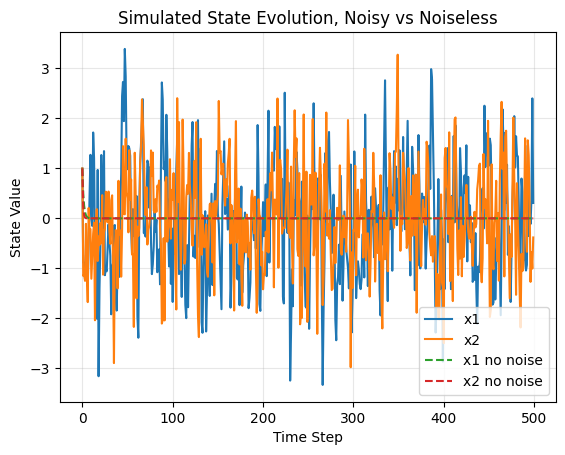

delta values:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
aoi values:  [2.0, 2.3125, 2.37890625, 2.394775390625, 2.3986968994140625, 2.399674415588379, 2.3999186158180237, 2.399979654699564, 2.399994913721457, 2.3999987284332747, 2.3999996821085006, 2.3999999205271365, 2.399999980131785, 2.399999995032946, 2.3999999987582363, 2.399999999689559, 2.3999999999223895, 2.399999999980597, 2.399999999995149, 2.399999999998787]


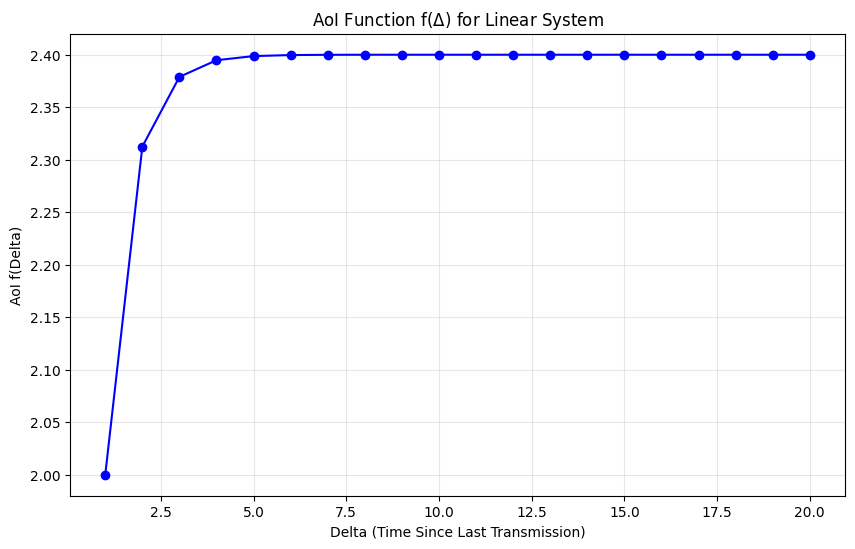

AoI function is increasing at delta = 2
AoI function is increasing at delta = 3
AoI function is increasing at delta = 4
AoI function is increasing at delta = 5
AoI function is increasing at delta = 6
AoI function is increasing at delta = 7
AoI function is increasing at delta = 8
AoI function is increasing at delta = 9
AoI function is increasing at delta = 10
AoI function is increasing at delta = 11
AoI function is increasing at delta = 12
AoI function is increasing at delta = 13
AoI function is increasing at delta = 14
AoI function is increasing at delta = 15
AoI function is increasing at delta = 16
AoI function is increasing at delta = 17
AoI function is increasing at delta = 18
AoI function is increasing at delta = 19
AoI function is increasing at delta = 20


In [7]:
##### this is for the linear case only ################### from dr .tripathi's paper
G = np.array([[0.5, 0.0], [0.0, 0.25]])
Sigma = np.eye(2) 
x_init = np.array([[1], [1]])
n_steps = 500
def f_AOI(G, Sigma, delta):
    sum = 0
    for i in range(delta): #0 to delta - 1
        G_k = np.linalg.matrix_power(G, i)
        G_k_T = G_k.T
        sum = sum + np.trace(G_k_T @ G_k @ Sigma)
    return sum
def gen_sim_data(G, Sigma, n_steps, x_init):
    #Sigma = np.zeros((2,2))
    x1_vals = [x_init[0][0]]
    x2_vals = [x_init[1][0]]
    for i in range(1, n_steps):
        noise = np.random.multivariate_normal(mean=[0,0], cov=Sigma).reshape((2,1))
        x_next = G @ np.array([[x1_vals[-1]], [x2_vals[-1]]]) + noise
        x1_vals.append(x_next[0][0])
        x2_vals.append(x_next[1][0])
    return x1_vals, x2_vals


x1_data, x2_data = gen_sim_data(G, Sigma, n_steps, x_init)
#also make data without noise for comparison
x_init_no_noise = np.array([[1], [1]])
x1_data_no_noise = [x_init_no_noise[0][0]]
x2_data_no_noise = [x_init_no_noise[1][0]]
for i in range(1, n_steps):
    x_next = G @ np.array([[x1_data_no_noise[-1]], [x2_data_no_noise[-1]]])
    x1_data_no_noise.append(x_next[0][0])
    x2_data_no_noise.append(x_next[1][0])


#just show the pregenerated data
plt.plot(x1_data, label='x1')
plt.plot(x2_data, label='x2')
plt.plot(x1_data_no_noise, label='x1 no noise', linestyle='--')
plt.plot(x2_data_no_noise, label='x2 no noise', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('State Value')
plt.title('Simulated State Evolution, Noisy vs Noiseless')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#plot the AoI function for different delta values
delta_values = list(range(1, 21))
aoi_values = [f_AOI(G, Sigma, delta) for delta in delta_values] 
print("delta values: ", delta_values)
print("aoi values: ", aoi_values)
plt.figure(figsize=(10, 6))
plt.plot(delta_values, aoi_values, marker='o', linestyle='-', color='blue')
plt.xlabel('Delta (Time Since Last Transmission)')
plt.ylabel('AoI f(Delta)')
plt.title('AoI Function f($\\Delta$) for Linear System')
plt.grid(True, alpha=0.3)
plt.show()

#check to make sure that the AoI function is increasing
for i in range(1, len(aoi_values)):
    if aoi_values[i] < aoi_values[i-1]:
        print("###########AoI function is not increasing at delta =", delta_values[i])
    else:
        print("AoI function is increasing at delta =", delta_values[i])

found threshold:  4
AoI evo from threshold:  [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 

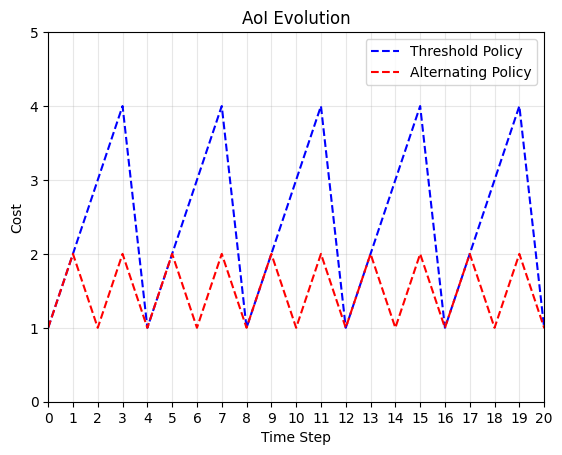

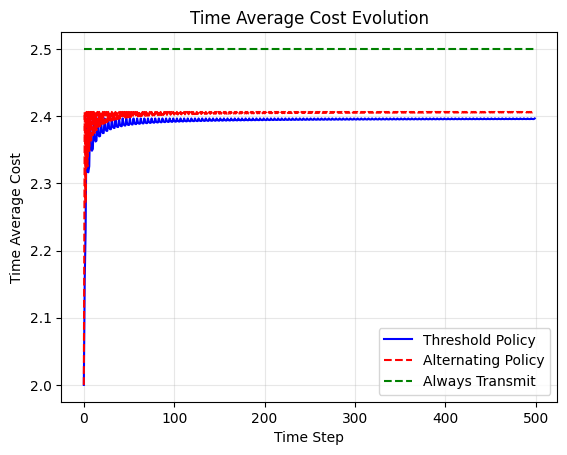

Final time average cost Threshold:  2.39654541015625
Final time average cost Alternating:  2.40625
Final time average cost Always Transmit:  2.5


In [8]:
def moving_time_average(A_pi_tracker, u_indicator_tracker):
    n = len(A_pi_tracker)
    time_avg_costs = []
    cumulative_cost = 0
    for k in range(n):
        cumulative_cost += f_AOI(G, Sigma, int(A_pi_tracker[k])) + u_indicator_tracker[k] * (C + 0)
        time_avg = cumulative_cost / (k + 1)
        time_avg_costs.append(time_avg)
    return time_avg_costs

def get_sum_to_h(H, G, Sigma):
    sum = 0
    for i in range(1, H+1):
        sum = sum + f_AOI(G, Sigma, i)
    return sum

def run_linear_simulation(policy, G, Sigma, x1_data, x2_data, n_steps, C):
    #first calculate threshold
    if(policy == "Threshold"):
        threshold_H = n_steps #because if we dont find one, we wait every time step
        H_max = n_steps
        for H in range(1, H_max):
            my_sum = get_sum_to_h(H, G, Sigma)
            this_lam = (my_sum + C) / H
            f_H = f_AOI(G, Sigma, H)
            f_H_1 = f_AOI(G, Sigma, H+1)
            if(f_H <= this_lam <= f_H_1):
                #found the H this is threshold
                threshold_H = H
                print("found threshold: ", threshold_H)
                break 
    # #assume we send the first data point
    # base_station_x1_vals = [x1_data[0]]
    # base_station_x2_vals = [x2_data[0]]
    base_station_x1_vals = []
    base_station_x2_vals = []
    k0_list = []
    A_pi_tracker = [] #aoi values under policy
    u_indicator_tracker = []  #1 is transmit, 0 if no transmit 
    aoi_flag = False
    #simulation loop
    for k in range(n_steps):
        x1 = x1_data[k]
        x2 = x2_data[k]
        # Calculate AoI cost
        #aoi = f_AOI(G, Sigma, k - k0_list[-1])
        A_k = k - k0_list[-1] + 0 if k0_list else k + 1  # Age since last transmission
        condition = True if (A_k >= threshold_H) else False
        if condition:
            aoi_flag = True
        #if the condition is true, go about it normally 
        #print("A_k: ", A_k)
        if(condition and aoi_flag): #transmission
            #send data
            base_station_x1_vals.append(x1)
            base_station_x2_vals.append(x2)
            k0_list.append(k)
            A_pi_tracker.append(A_k)
            u_indicator_tracker.append(1)
        elif(not condition and aoi_flag):
            #dont send data 
            A_pi_tracker.append(1)
            u_indicator_tracker.append(0)
            aoi_flag = False
        else: 
            #no transmission
            A_pi_tracker.append(A_k)
            u_indicator_tracker.append(0)
        # if(condition): #transmission
        #     #send data
        #     base_station_x1_vals.append(x1)
        #     base_station_x2_vals.append(x2)
        #     k0_list.append(k)
        #     A_pi_tracker.append(1)
        #     u_indicator_tracker.append(1)
        #     #aoi_flag = True
        #     #total_cost_tracker.append(total_cost_tracker[-1] + C)
        # # else: #no transmission
        # #     # Instantaneous monitoring cost at age current_delta
        # #     if current_delta == 0:
        # #         instant_cost = 0
        # #     else:
        # #         G_k = np.linalg.matrix_power(G, current_delta - 1)
        # #         instant_cost = np.trace(G_k.T @ G_k @ Sigma)
        # #     total_cost_tracker.append(total_cost_tracker[-1] + instant_cost)
        # else: #no transmission
        #     #f_aoi = f_AOI(G, Sigma, current_aoi)
        #     A_pi_tracker.append(A_k)
        #     u_indicator_tracker.append(0)
            #total_cost_tracker.append(total_cost_tracker[-1] + aoi)
            #total_cost_tracker.append(total_cost_tracker[-1] + aoi - f_AOI(G, Sigma, current_delta - 1))
    return base_station_x1_vals, base_station_x2_vals, k0_list, A_pi_tracker, u_indicator_tracker

C = 0.5
base_station_x1_vals_t, base_station_x2_vals_t, k0_list_t, A_pi_tracker_t, u_indicator_tracker_t = \
    run_linear_simulation("Threshold", G, Sigma, x1_data, x2_data, n_steps, C)
#make the alternating one(alternates between 1 and 2)
A_pi_tracker_a = []
u_indicator_tracker_a = []
for i in range(n_steps):
    if(i % 2 == 0):
        A_pi_tracker_a.append(1)
        u_indicator_tracker_a.append(0)
    else:
        A_pi_tracker_a.append(2)
        u_indicator_tracker_a.append(1)

print("AoI evo from threshold: ", A_pi_tracker_t)
print("u indicator from threshold: ", u_indicator_tracker_t)
print(len(A_pi_tracker_t))
print(len(u_indicator_tracker_t))
print("AoI evo from alternating: ", A_pi_tracker_a)
print("u indicator from alternating: ", u_indicator_tracker_a)
x_axis = list(range(n_steps))
plt.plot(x_axis, A_pi_tracker_t, label='Threshold Policy', linestyle='--', color='blue')
plt.plot(x_axis, A_pi_tracker_a, label='Alternating Policy',linestyle='--', color='red')
#only show integer ticks
plt.yticks(range(0, 6, 1))
plt.xticks(range(0, 21, 1))
plt.xlim(0, 20)
plt.xlabel('Time Step')
plt.ylabel('Cost')
plt.title('AoI Evolution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
#Now that we have access to the AOI and indicationr function, we can calculate the time average cost
#at each time step, aka a moving time average 
time_avg_costs_t = moving_time_average(A_pi_tracker_t, u_indicator_tracker_t)
time_avg_costs_a = moving_time_average(A_pi_tracker_a, u_indicator_tracker_a)
#transmit_every_step =  [i*C for i in range(n_steps)]
aoi_always_transmit = np.ones(n_steps)  # AoI is always 1 when transmitting every step
u_indicator_always_transmit = np.ones(n_steps)  # Always transmitting
time_avg_costs_always = moving_time_average(aoi_always_transmit, u_indicator_always_transmit)
plt.plot(time_avg_costs_t, label='Threshold Policy', color='blue')
plt.plot(time_avg_costs_a, label='Alternating Policy',linestyle = '--', color='red')
plt.plot(time_avg_costs_always, label='Always Transmit',linestyle = '--', color='green')
plt.xlabel('Time Step')
plt.ylabel('Time Average Cost')
plt.title('Time Average Cost Evolution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
#final time average costs
print("Final time average cost Threshold: ", time_avg_costs_t[-1])
print("Final time average cost Alternating: ", time_avg_costs_a[-1])
print("Final time average cost Always Transmit: ", time_avg_costs_always[-1])


# #I get threshold is 4 so lets check
# print("f(4) = ", f_AOI(G, Sigma, 4))
# print("f(5) = ", f_AOI(G, Sigma, 5))
# my_sum = get_sum_to_h(4, G, Sigma)
# sum_2 =  f_AOI(G, Sigma, 1) + f_AOI(G, Sigma, 2) + f_AOI(G, Sigma, 3) + f_AOI(G, Sigma, 4)
# print("sum to 4: ", my_sum)
# this_lam = (my_sum + C) / 4
# print("lambda for H=4: ", this_lam)
# print("f(0) = ", f_AOI(G, Sigma, 0))

# print("f(1) = ", f_AOI(G, Sigma, 1))
# print("f(2) = ", f_AOI(G, Sigma, 2))
# my_sum = get_sum_to_h(1, G, Sigma)
# print("sum: ", my_sum)
# l = (my_sum + C) / 1
# print("lambda for H = 1: ", l)




In [9]:
#Now that we have the linear system version from the paper working
#we need to use the koopman version on the linear one and compare, see how close to being optimal 
#it is 

Using  OPTIMAL  policy
found threshold:  4
Preocomputed K_rls_noise norm:  5.189398578102009
Using  KOOPMAN  policy
found threshold:  1


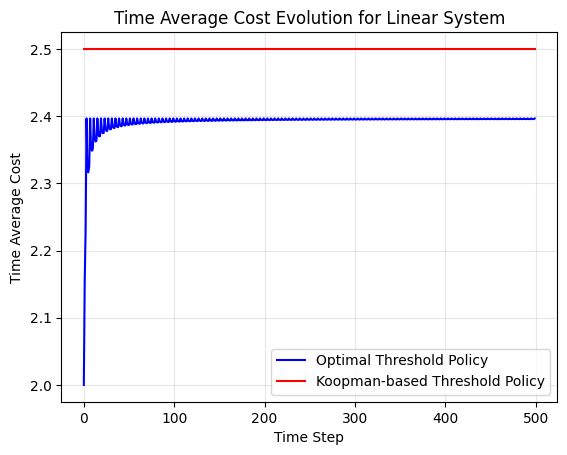

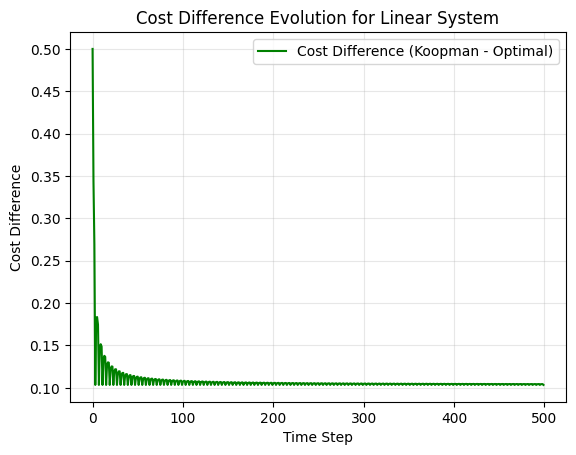

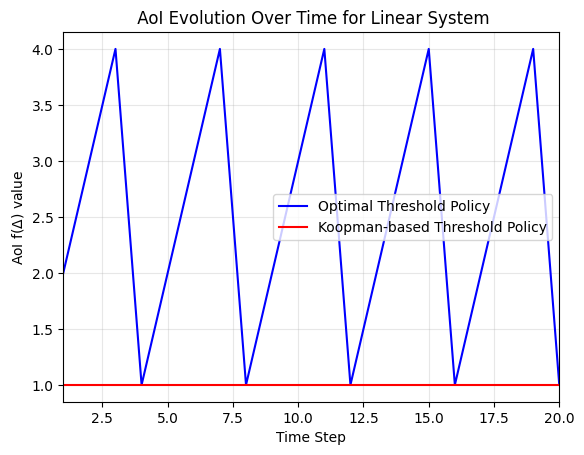

Final time average cost Optimal Threshold:  2.39654541015625
Final time average cost Koopman Threshold:  2.5
AoI Optimal Threshold:  [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1,

In [ ]:
#Do what we did before but change it so it works with any precomputed data, 
#also does time average
#and then use on linear system 
def run_2D_general_sim(policy, G, Sigma, x1_data, x2_data, C, f_AOI_function, degree):
    n_steps = len(x1_data)
    K_rls_noise = None
    K_rls_no_noise = None
    #if it is koopman, we go from data and do not need G and Sigma
    #but we do need to precompute K_rls from noiseless data
    if(f_AOI_function == "KOOPMAN"):
        # Basis size
        n_basis = 2 + (degree + 1)**2
        n_steps = len(I_actual_vals)
        # RLS state for row vector formulation: phi_next = phi @ K_rls
        P_noisy = alpha * np.eye(n_basis)
        K_rls_noise = np.zeros((n_basis, n_basis))  # Koopman trained on noisy data
        K_rls_no_noise = K_rls.copy()  # Initialize noise-free koopman from previous cell
        #GETTING RID OF WARMUP
        #use all the data to precompute the noisey koopman from actual system dynamics
        fake_base_station_I_vals = [I_actual_vals[0]]
        fake_base_station_R_vals = [R_actual_vals[0]]
        fake_k0_list = [0]
        for i in range(1, 80): #if the norm is too big, it becomes the alternating policy
        #for i in range(1, len(I_actual_vals) - 1):
            fake_base_station_I_vals.append(I_actual_vals[i])
            fake_base_station_R_vals.append(R_actual_vals[i])
            fake_k0_list.append(i)
            state = np.array([[I_actual_vals[i]], [R_actual_vals[i]]])
            K_rls_noise, P_noisy = rls_update(P_noisy, fake_base_station_I_vals, fake_base_station_R_vals, fake_k0_list, state, degree, lambda_rls, K_rls_noise)

        #precomputing of K hat is complete
        print("Preocomputed K_rls_noise norm: ", np.linalg.norm(K_rls_noise, ord='fro'))

    #calculate threshold
    if(policy == "Threshold"):
        threshold_H = n_steps + 1 #because if we dont find one, we wait every time step
        H_max = n_steps
        for H in range(1, H_max):
            #choose which AOI function to use
            if(f_AOI_function == "OPTIMAL"):
                f_H = f_AOI(G, Sigma, H)
                f_H_1 = f_AOI(G, Sigma, H+1)
                my_sum = get_sum_to_h(H, G, Sigma)
                this_lam = (my_sum + C) / H
            elif(f_AOI_function == "KOOPMAN"):
                f_H = upper_upper_bound(K_rls_no_noise, K_rls_noise, H)
                f_H_1 = upper_upper_bound(K_rls_no_noise, K_rls_noise, H+1)
                my_sum = sum_to_h(H, K_rls_no_noise, K_rls_noise)
                this_lam = (my_sum + C) / H
            if(f_H <= this_lam <= f_H_1):
                #found the H this is threshold
                threshold_H = H
                break 
        #have an option where the user chooses a thoreshold
        # if the policy is a number instead of a string, use that as threshold
        if(isinstance(policy, int)):
            threshold_H = policy
        print("Using ", f_AOI_function, " policy")
        print("found threshold: ", threshold_H)
    # #assume we send the first data point
    # base_station_x1_vals = [x1_data[0]]
    # base_station_x2_vals = [x2_data[0]]
    base_station_x1_vals = []
    base_station_x2_vals = []
    k0_list = []
    A_pi_tracker = [] #aoi values under policy
    u_indicator_tracker = []  #1 is transmit, 0 if no transmit 
    aoi_flag = False
    #simulation loop
    for k in range(n_steps):
        x1 = x1_data[k]
        x2 = x2_data[k]
        # Calculate AoI cost
        #aoi = f_AOI(G, Sigma, k - k0_list[-1])
        A_k = k - k0_list[-1] + 0 if k0_list else k + 1  # Age since last transmission
        condition = True if (A_k >= threshold_H) else False
        if condition:
            aoi_flag = True
        #if the condition is true, go about it normally 
        #print("A_k: ", A_k)
        if(condition and aoi_flag): #transmission
            #send data
            base_station_x1_vals.append(x1)
            base_station_x2_vals.append(x2)
            k0_list.append(k)
            A_pi_tracker.append(A_k)
            u_indicator_tracker.append(1)
        elif(not condition and aoi_flag):
            #dont send data 
            A_pi_tracker.append(1)
            u_indicator_tracker.append(0)
            aoi_flag = False
        else: 
            #no transmission
            A_pi_tracker.append(A_k)
            u_indicator_tracker.append(0)

    return base_station_x1_vals, base_station_x2_vals, k0_list, A_pi_tracker, u_indicator_tracker, K_rls_noise, K_rls_no_noise


#define sim parameters
C = 0.5
degree = 6
base_station_x1_vals_o_t, base_station_x2_vals_o_t, k0_list_o_t, A_pi_tracker_o_t, u_indicator_tracker_o_t, K_rls_noise_o_t, K_rls_no_noise_o_t = \
    run_2D_general_sim("Threshold", G, Sigma, x1_data, x2_data, C, "OPTIMAL", degree)
base_station_x1_vals_k_t, base_station_x2_vals_k_t, k0_list_k_t, A_pi_tracker_k_t, u_indicator_tracker_k_t, K_rls_noise_k_t, K_rls_no_noise_k_t = \
    run_2D_general_sim("Threshold", G, Sigma, x1_data, x2_data, C, "KOOPMAN", degree)
#moving time average costs
time_avg_costs_o_t = moving_time_average(A_pi_tracker_o_t, u_indicator_tracker_o_t)
time_avg_costs_k_t = moving_time_average(A_pi_tracker_k_t, u_indicator_tracker_k_t)
#plot time average costs
plt.plot(time_avg_costs_o_t, label='Optimal Threshold Policy', color='blue')
plt.plot(time_avg_costs_k_t, label='Koopman-based Threshold Policy', color='red')
plt.xlabel('Time Step')
plt.ylabel('Time Average Cost')
plt.title('Time Average Cost Evolution for Linear System')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Now plot differences in cost at each step
cost_differences = -(np.array(time_avg_costs_o_t) - np.array(time_avg_costs_k_t))
plt.plot(cost_differences, label='Cost Difference (Koopman - Optimal)', color='green')
plt.xlabel('Time Step')
plt.ylabel('Cost Difference')
plt.title('Cost Difference Evolution for Linear System')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#plot AoI evolutions
plt.plot(A_pi_tracker_o_t, label='Optimal Threshold Policy', color='blue')
plt.plot(A_pi_tracker_k_t, label='Koopman-based Threshold Policy', color='red')
plt.xlim(1, 20)
plt.xlabel('Time Step')
plt.ylabel('AoI f($\Delta$) value')
plt.title(' AoI Evolution Over Time for Linear System')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#print out the final time average costs
print("Final time average cost Optimal Threshold: ", time_avg_costs_o_t[-1])
print("Final time average cost Koopman Threshold: ", time_avg_costs_k_t[-1])    

#also print out the aoi's and indicator functions
print("AoI Optimal Threshold: ", A_pi_tracker_o_t)
print("u indicator Optimal Threshold: ", u_indicator_tracker_o_t)
print("AoI Koopman Threshold: ", A_pi_tracker_k_t)
print("u indicator Koopman Threshold: ", u_indicator_tracker_k_t)

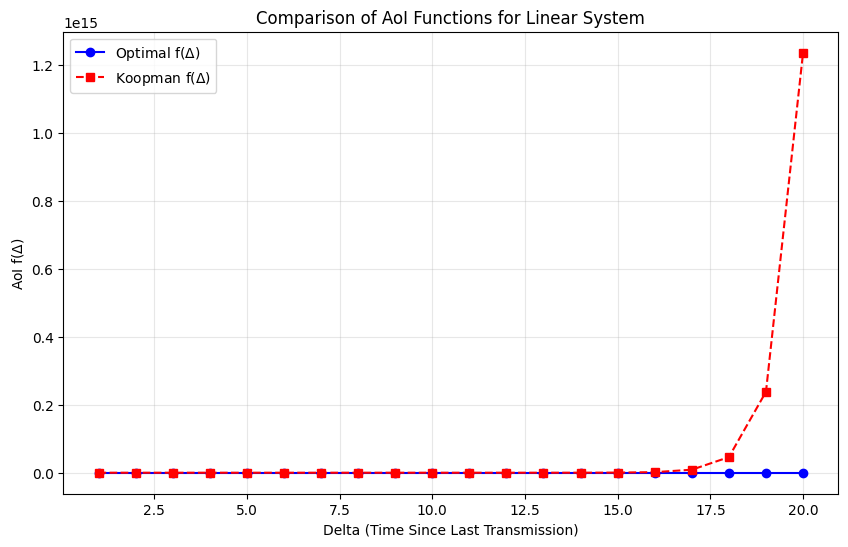

Optimal AoI values:  [2.0, 2.3125, 2.37890625, 2.394775390625, 2.3986968994140625, 2.399674415588379, 2.3999186158180237, 2.399979654699564, 2.399994913721457, 2.3999987284332747, 2.3999996821085006, 2.3999999205271365, 2.399999980131785, 2.399999995032946, 2.3999999987582363, 2.399999999689559, 2.3999999999223895, 2.399999999980597, 2.399999999995149, 2.399999999998787]
Koopman AoI values:  [50.560627555550845, 221.9542045414568, 1030.023606426912, 4978.310637774246, 24729.13139250401, 124999.45196140351, 638640.3591093583, 3283937.932241034, 16950617.17592961, 87689222.85068825, 454228009.90161926, 2354680806.578144, 12211877671.408493, 63349707318.062675, 328678816073.2349, 1705440326900.6846, 8849591858383.473, 45922198364530.95, 238302984286627.56, 1236632277239972.8]
f(1) =  50.560627555550845
f(2) =  221.9542045414568
lambda =  273.0148320970076
[50.560627555550845, 221.9542045414568, 1030.023606426912, 4978.310637774246, 24729.13139250401, 124999.45196140351, 638640.3591093583,

In [11]:
#plot the f aoi function for both optimal and koopman
delta_values = list(range(1, 21))
aoi_optimal_values = [f_AOI(G, Sigma, delta) for delta in delta_values]
aoi_koopman_values = [upper_upper_bound(K_rls_no_noise_k_t, K_rls_noise_k_t, delta) for delta in delta_values]
plt.figure(figsize=(10, 6))
plt.plot(delta_values, aoi_optimal_values, marker='o', linestyle='-', color='blue', label='Optimal f($\\Delta$)')
plt.plot(delta_values, aoi_koopman_values, marker='s', linestyle='--', color='red', label='Koopman f($\\Delta$)')
plt.xlabel('Delta (Time Since Last Transmission)')
plt.ylabel('AoI f($\\Delta$)')
plt.title('Comparison of AoI Functions for Linear System')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
print("Optimal AoI values: ", aoi_optimal_values)
print("Koopman AoI values: ", aoi_koopman_values)
print("f(1) = ", aoi_koopman_values[0])
print("f(2) = ", aoi_koopman_values[1])
print("lambda = ", (aoi_koopman_values[0] + aoi_koopman_values[1] + C) / 1)

#print function values
print(aoi_koopman_values)
print(aoi_optimal_values)

Using  OPTIMAL  policy
found threshold:  1
Preocomputed K_rls_noise norm:  5.189398578102009
Using  KOOPMAN  policy
found threshold:  1


/var/folders/x7/qvx5b4kx5x9f3cn0qtqz24nm0000gr/T/ipykernel_20853/2377827583.py:19: RuntimeWarning: overflow encountered in matmul
  x_next = G @ np.array([[x1_vals[-1]], [x2_vals[-1]]]) + noise
/var/folders/x7/qvx5b4kx5x9f3cn0qtqz24nm0000gr/T/ipykernel_20853/2377827583.py:19: RuntimeWarning: invalid value encountered in matmul
  x_next = G @ np.array([[x1_vals[-1]], [x2_vals[-1]]]) + noise


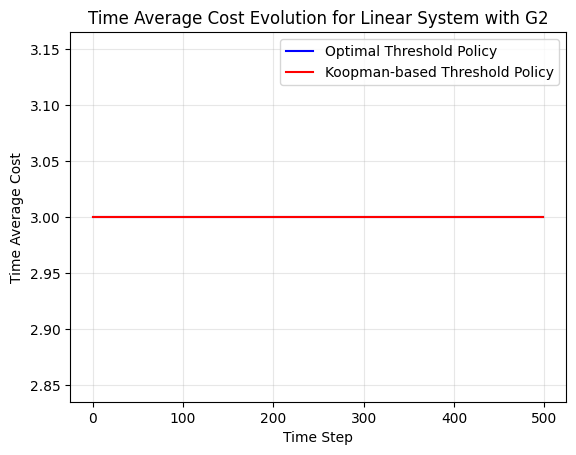

In [12]:
#I Think C has to be pretty high for koopman to do something besides always transmit

#Next, try the same comparisons but with a different G matrix to see what kind 
#of results we get, also can we quantify how close the koopman one is to optimal?
G2 = np.array([[0.8, 100], [100, -0.6]])
Sigma2 = np.eye(2) * 0.5 
x_init2 = np.array([[1], [1]])
x1_data2, x2_data2 = gen_sim_data(G2, Sigma2, n_steps, x_init2)
#now run for koopman and optimal
C = 1
degree = 6

base_station_x1_vals_o_t2, base_station_x2_vals_o_t2, k0_list_o_t2, A_pi_tracker_o_t2, u_indicator_tracker_o_t2, K_rls_noise_o_t2, K_rls_no_noise_o_t2 = \
    run_2D_general_sim("Threshold", G2, Sigma2, x1_data2, x2_data2, C, "OPTIMAL", degree)
base_station_x1_vals_k_t2, base_station_x2_vals_k_t2, k0_list_k_t2, A_pi_tracker_k_t2, u_indicator_tracker_k_t2, K_rls_noise_k_t2, K_rls_no_noise_k_t2 = \
    run_2D_general_sim("Threshold", G2, Sigma2, x1_data2, x2_data2, C, "KOOPMAN", degree)
#moving time average costs
time_avg_costs_o_t2 = moving_time_average(A_pi_tracker_o_t2, u_indicator_tracker_o_t2)
time_avg_costs_k_t2 = moving_time_average(A_pi_tracker_k_t2, u_indicator_tracker_k_t2)
#plot time average costs
plt.plot(time_avg_costs_o_t2, label='Optimal Threshold Policy', color='blue')
plt.plot(time_avg_costs_k_t2, label='Koopman-based Threshold Policy', color='red')
plt.xlabel('Time Step')
plt.ylabel('Time Average Cost')
plt.title('Time Average Cost Evolution for Linear System with G2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


#The optimal cost function plataues, but the koopman one is exponentially increasing
#This means that the cost must be pretty high to get a non-trivial policy from koopman
#However, a high cost also means that the optimal policy is to never transmit, which is not exciting
